### Install and load necessary packages

In [1]:
BUCKET_NAME = "YOUR_BUCKET"

# Change "mask_name" when changing the mask image. Mask is not used if set to mask_name=0.
mask_name = "0"

In [2]:
%%capture
!pip install -r /home/neuro/codes/questionnaire_brain/requirements_multivariate_prediction.txt

In [3]:
%%capture
%cd /home/neuro
!git clone https://github.com/netneurolab/neuromaps
%cd neuromaps
!pip install .
%cd /home/neuro

In [4]:
%matplotlib inline

import os
import pickle
import boto3
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from noglobal import NoGlobal
noglobal = NoGlobal(globals()).noglobal
from nltools.data import Brain_Data
from neuromaps import datasets, images, nulls, resampling, stats

pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
# Create directories if they do not exist.
if not os.path.exists('/root/.aws'):
    os.makedirs('/root/.aws')
    # Put credential on host into guest
    ! cp /home/neuro/credential/your_s3_credentials ~/.aws/credentials

In [6]:
# boto3
@noglobal
def cp_s3(BUCKET_NAME, FROM_PATH, TO_PATH, FILE_NAME, download_or_upload):
    s3_resource = boto3.resource('s3')
    bucket = s3_resource.Bucket(BUCKET_NAME)

    from_path = os.path.join(FROM_PATH, FILE_NAME)
    to_path = os.path.join(TO_PATH, FILE_NAME)
    
    if download_or_upload == "download":
        bucket.download_file(from_path, to_path)
    elif download_or_upload == "upload":
        bucket.upload_file(from_path, to_path)
    else:
        raise ValueError('Please specify download or upload.')
    return

### Load weight_map

In [7]:
FROM_PATH = os.path.join("outputdir/multivariate_prediction_output", mask_name)
TO_PATH = os.path.join("/home/neuro/mount/data_files/multivariate_prediction_output", mask_name)

# Create directories if they do not exist.
if not os.path.exists(TO_PATH):
    os.makedirs(TO_PATH)
    
FILE_NAME = "weight_maps_list.pickle"
cp_s3(BUCKET_NAME, FROM_PATH, TO_PATH, FILE_NAME, "download")
with open(os.path.join(TO_PATH, FILE_NAME), 'rb') as f:
    weight_maps_list = pickle.load(f)

FILE_NAME = "df_con_name_FDR_q.pickle"
cp_s3(BUCKET_NAME, FROM_PATH, TO_PATH, FILE_NAME, "download")
with open(os.path.join(TO_PATH, FILE_NAME), 'rb') as f:
    df_con_name_FDR_q = pickle.load(f)

FILE_NAME = "df_con_name_FDR_q_005.pickle"
cp_s3(BUCKET_NAME, FROM_PATH, TO_PATH, FILE_NAME, "download")
with open(os.path.join(TO_PATH, FILE_NAME), 'rb') as f:
    df_con_name_FDR_q_005 = pickle.load(f)

In [8]:
df_con_name_FDR_q

,con_name,p,FDR_q
0,Social vs Control,0.000,0.000
1,Food vs Control,0.000,0.000
2,Social vs Food,0.000,0.000
3,isolation vs baseline,0.060,0.087
4,fasting vs baseline,0.412,0.439
5,isolation vs fasting,0.000,0.000
6,Social_isolation vs Social_baseline,0.204,0.251
7,Social_fasting vs Social_baseline,0.530,0.530
8,Social_isolation vs Social_fasting,0.000,0.000
9,Food_isolation vs Food_baseline,0.012,0.021


In [9]:
df_con_name_FDR_q_005

,con_name,p,FDR_q
0,Social vs Control,0.000,0.000
1,Food vs Control,0.000,0.000
2,Social vs Food,0.000,0.000
5,isolation vs fasting,0.000,0.000
8,Social_isolation vs Social_fasting,0.000,0.000
9,Food_isolation vs Food_baseline,0.012,0.021
11,Food_isolation vs Food_fasting,0.000,0.000
14,Control_isolation vs Control_fasting,0.000,0.000
15,Rewarded vs NonRewarded,0.000,0.000


In [10]:
# Transfer the loaded data of weight maps to a NIfTI image
for num in range(len(weight_maps_list)):
    weight_maps_list[num] = weight_maps_list[num].to_nifti()

In [11]:
# Create a list of images and its names
img_list = weight_maps_list
img_list_str = df_con_name_FDR_q_005["con_name"].to_list()

In [12]:
# Decide which condition to analyze
analysis_weight_maps_list = ['Social vs Control', 'Food vs Control', 'isolation vs fasting', 'Rewarded vs NonRewarded']

### 1. Gene expression analysis

Lists to make: tempalate_list, template_list_str, rotated_dict, img_name_list (common), template_name_list, corr_list, pval_list, nulls_dist_list

In [13]:
# Download Neurosynth - Gene from https://neurosynth.org/genes/DRD1/

img_DRD1 = nib.load("/home/neuro/codes/gene/gene_1800_DRD1_1812.0.nii.gz")
img_DRD2 = nib.load("/home/neuro/codes/gene/gene_1801_DRD2_1813.0.nii.gz")
img_DRD3 = nib.load("/home/neuro/codes/gene/gene_1802_DRD3_1814.0.nii.gz")
img_DRD4 = nib.load("/home/neuro/codes/gene/gene_1803_DRD4_1815.0.nii.gz")
img_DRD5 = nib.load("/home/neuro/codes/gene/gene_1804_DRD5_1816.0.nii.gz")
img_OPRD1 = nib.load("/home/neuro/codes/gene/gene_4953_OPRD1_4985.0.nii.gz")
img_OPRK1 = nib.load("/home/neuro/codes/gene/gene_4954_OPRK1_4986.0.nii.gz")
img_OPRM1 = nib.load("/home/neuro/codes/gene/gene_4956_OPRM1_4988.0.nii.gz")
img_OPRL1 = nib.load("/home/neuro/codes/gene/gene_4955_OPRL1_4987.0.nii.gz")
img_HTR1A = nib.load("/home/neuro/codes/gene/gene_3330_HTR1A_3350.0.nii.gz")
img_HTR1B = nib.load("/home/neuro/codes/gene/gene_3331_HTR1B_3351.0.nii.gz")
img_HTR1D = nib.load("/home/neuro/codes/gene/gene_3332_HTR1D_3352.0.nii.gz")
img_HTR1E = nib.load("/home/neuro/codes/gene/gene_3334_HTR1E_3354.0.nii.gz")
img_HTR1F = nib.load("/home/neuro/codes/gene/gene_3335_HTR1F_3355.0.nii.gz")
img_HTR2A = nib.load("/home/neuro/codes/gene/gene_3336_HTR2A_3356.0.nii.gz")
img_HTR2B = nib.load("/home/neuro/codes/gene/gene_3337_HTR2B_3357.0.nii.gz")
img_HTR2C = nib.load("/home/neuro/codes/gene/gene_3338_HTR2C_3358.0.nii.gz")
img_HTR3A = nib.load("/home/neuro/codes/gene/gene_3339_HTR3A_3359.0.nii.gz")
img_HTR3B = nib.load("/home/neuro/codes/gene/gene_9053_HTR3B_9177.0.nii.gz")
img_HTR3C = nib.load("/home/neuro/codes/gene/gene_81892_HTR3C_170572.0.nii.gz")
img_HTR3D = nib.load("/home/neuro/codes/gene/gene_83600_HTR3D_200909.0.nii.gz")
img_HTR3E = nib.load("/home/neuro/codes/gene/gene_94515_HTR3E_285242.0.nii.gz")
img_HTR4  = nib.load("/home/neuro/codes/gene/gene_3340_HTR4_3360.0.nii.gz")
img_HTR5A = nib.load("/home/neuro/codes/gene/gene_3341_HTR5A_3361.0.nii.gz")
img_HTR6  = nib.load("/home/neuro/codes/gene/gene_3342_HTR6_3362.0.nii.gz")
img_HTR7  = nib.load("/home/neuro/codes/gene/gene_3343_HTR7_3363.0.nii.gz")
img_OXTR = nib.load("/home/neuro/codes/gene/gene_4989_OXTR_5021.0.nii.gz")
img_OXT  = nib.load("/home/neuro/codes/gene/gene_4988_OXT_5020.0.nii.gz")

In [14]:
template_list = [img_DRD1, img_DRD2, img_DRD3, img_DRD4, img_DRD5, img_OPRD1, img_OPRK1, img_OPRM1, img_OPRL1,
                 img_HTR1A, img_HTR1B, img_HTR1D, img_HTR1E, img_HTR1F, img_HTR2A, img_HTR2B, img_HTR2C, img_HTR3A, img_HTR3B, img_HTR3C, img_HTR3D, img_HTR3E, img_HTR4, img_HTR5A, img_HTR6, img_HTR7,
                 img_OXTR, img_OXT
                ]
template_list_str = ["D$_{1}$", "D$_{2}$", "D$_{3}$", "D$_{4}$", "D$_{5}$", "DOR", "KOR", "MOR", "NOP",
                     "5-HT$_{1A}$", "5-HT$_{1B}$", "5-HT$_{1D}$", "5-HT$_{1E}$", "5-HT$_{1F}$", "5-HT$_{2A}$", "5-HT$_{2B}$", "5-HT$_{2C}$", "5-HT$_{3A}$", "5-HT$_{3B}$", "5-HT$_{3C}$", "5-HT$_{3D}$", "5-HT$_{3E}$", "5-HT$_{4}$", "5-HT$_{5A}$", "5-HT$_{6}$", "5-HT$_{7}$",
                     "OXTR", "OXT"
                    ]

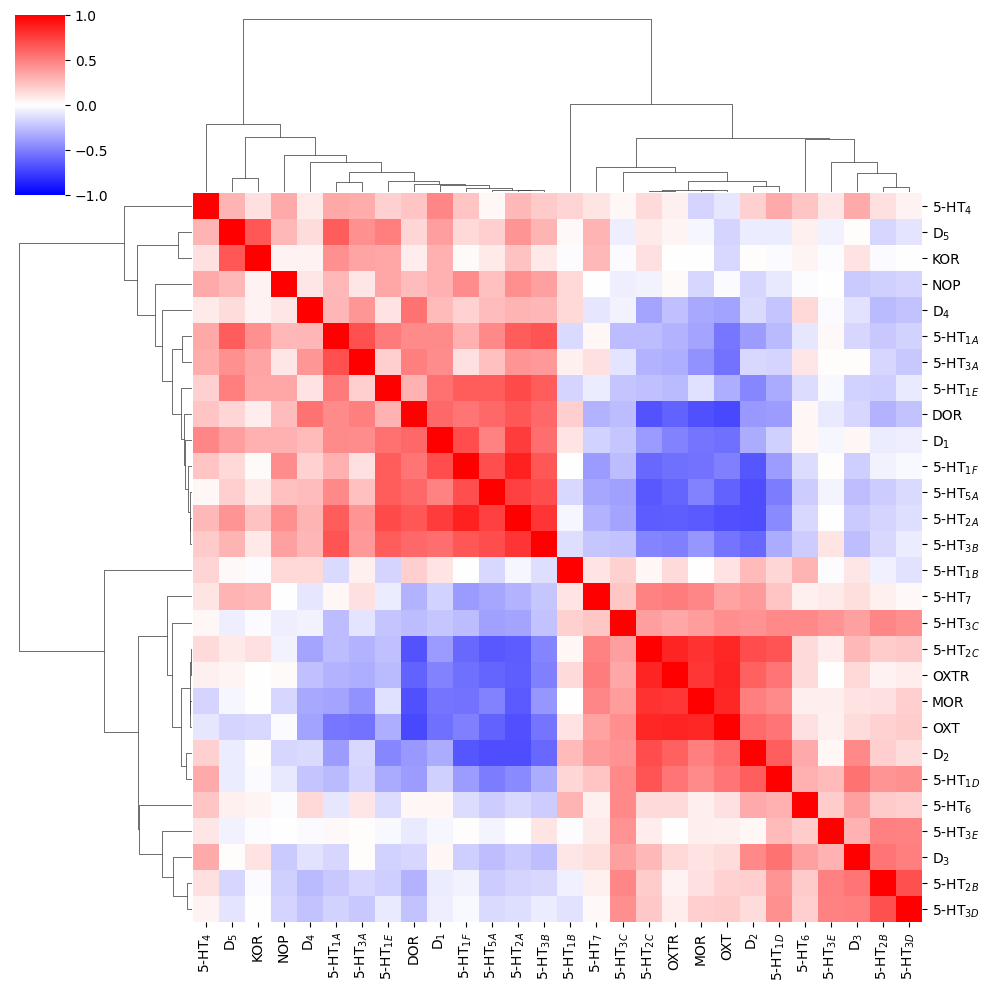

In [15]:
# Calculate the correlation between the template images (gene expression mappings)
temp_maps_data_list = []
for num in range(len(template_list)):
    template0 = template_list[num]
    template, img = resampling.resample_images(template0, template0, 'MNI152', 'MNI152', resampling='transform_to_alt', alt_spec=('fsaverage', '10k'))
    temp_maps_data_list.append(np.hstack([template[0].agg_data(), template[1].agg_data()]))

df = pd.DataFrame(temp_maps_data_list, index=template_list_str).T
df.head()

df_corr = df.corr()
cg = sns.clustermap(df_corr, annot=False, fmt=".2f", cmap="bwr", vmin=-1, vmax=1, metric="correlation")
#cg.ax_row_dendrogram.set_visible(False)
#cg.ax_col_dendrogram.set_visible(False)

In [ ]:
# Create a set of null maps for each template
rotated_dict = {}
for template_num, template in enumerate(template_list):
    template_name = template_list_str[template_num]
    print("Starting resampling!")
    resampled_template, resampled_img = resampling.resample_images(template, img_list[0], 'MNI152', 'MNI152', resampling='transform_to_alt', alt_spec=('fsaverage', '10k'))
    print("Finished resampling!")
    rotated_dict[template_name] = nulls.alexander_bloch(resampled_template, atlas='fsaverage', density='10k', n_perm=1000, seed=1234)
    print("Finished rotating/creating null maps!")
    print(rotated_dict[template_name].shape)

Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!
Finished rotating/

In [17]:
img_name_list = []
template_name_list = []
corr_list = []
pval_list = []
null_dist_list = []

for img_num, img in enumerate(img_list):
    img_name = img_list_str[img_num]
    if img_name in analysis_weight_maps_list:
        for template_num, template in enumerate(template_list):
            template_name = template_list_str[template_num]
            print(f'img = {img_name}, template = {template_name}')
            
            # Resampled the template and the image
            resampled_template, resampled_img = resampling.resample_images(template, img, 'MNI152', 'MNI152', resampling='transform_to_alt', alt_spec=('fsaverage', '10k'))

            # Use pre-computed 'rotated' value
            rotated = rotated_dict[template_name]
            
            corr, pval, nulls_dist = stats.compare_images(resampled_template, resampled_img, nulls=rotated, return_nulls = True )

            print(f'r = {corr:.3f}, p = {pval:.3f}')
            img_name_list.append(img_name)
            template_name_list.append(template_name)
            corr_list.append(corr)
            pval_list.append(pval)
            null_dist_list.append(nulls_dist)

r = -0.008, p = 0.667
img = Food vs Control, template = 5-HT$_{4}$
r = 0.028, p = 0.228
img = Food vs Control, template = 5-HT$_{5A}$
r = 0.047, p = 0.054
img = Food vs Control, template = 5-HT$_{6}$
r = 0.012, p = 0.556
img = Food vs Control, template = 5-HT$_{7}$
r = -0.037, p = 0.086
img = Food vs Control, template = OXTR
r = -0.050, p = 0.069
img = Food vs Control, template = OXT
r = -0.083, p = 0.005
img = isolation vs fasting, template = D$_{1}$
r = -0.323, p = 0.001
img = isolation vs fasting, template = D$_{2}$
r = 0.258, p = 0.002
img = isolation vs fasting, template = D$_{3}$
r = 0.027, p = 0.452
img = isolation vs fasting, template = D$_{4}$
r = -0.256, p = 0.001
img = isolation vs fasting, template = D$_{5}$
r = -0.082, p = 0.155
img = isolation vs fasting, template = DOR
r = -0.449, p = 0.001
img = isolation vs fasting, template = KOR
r = -0.063, p = 0.337
img = isolation vs fasting, template = MOR
r = 0.526, p = 0.001
img = isolation vs fasting, template = NOP
r = -0.010,

In [18]:
# Adjust p-values to control the false discovery rate.
FDR_pval_list = sp.stats.false_discovery_control(pval_list, axis=0, method='bh')

# The main result here is the FDR_pval for image-template combination
df = pd.DataFrame([img_name_list, template_name_list, corr_list, pval_list, FDR_pval_list, null_dist_list],
                  index=["img", "template", "corr", "pval", "FDR_pval" ,"null_dist"]).T

df['img_template'] = df['img'] + " x " + df['template']

df.loc[df['FDR_pval'] > .05 , 'star'] = ''
df.loc[df['FDR_pval'] < .05 , 'star'] = '*'
df.loc[df['FDR_pval'] < .01 , 'star'] = '**'
df.loc[df['FDR_pval'] < .005, 'star'] = '***'

df

,img,template,corr,pval,FDR_pval,null_dist,img_template,star
0,Social vs Control,D$_{1}$,-0.117,0.001,0.004,"[0.055655695497989655, -0.05856312811374664, 0...",Social vs Control x D$_{1}$,***
1,Social vs Control,D$_{2}$,0.050,0.107,0.166,"[-0.036113664507865906, 0.11509880423545837, -...",Social vs Control x D$_{2}$,
2,Social vs Control,D$_{3}$,-0.000,0.994,0.994,"[0.006707530934363604, 0.03195285424590111, -0...",Social vs Control x D$_{3}$,
3,Social vs Control,D$_{4}$,-0.070,0.014,0.031,"[0.05235270410776138, -0.01739604026079178, 0....",Social vs Control x D$_{4}$,*
4,Social vs Control,D$_{5}$,-0.024,0.415,0.469,"[0.008402207866311073, -0.016745569184422493, ...",Social vs Control x D$_{5}$,
5,Social vs Control,DOR,-0.134,0.001,0.004,"[0.05704684928059578, -0.07291623204946518, 0....",Social vs Control x DOR,***
6,Social vs Control,KOR,-0.026,0.382,0.445,"[0.005696355365216732, 0.018955817446112633, -...",Social vs Control x KOR,
7,Social vs Control,MOR,0.139,0.001,0.004,"[-0.07998873293399811, 0.1144830733537674, -0....",Social vs Control x MOR,***
8,Social vs Control,NOP,0.045,0.068,0.115,"[-0.00977818388491869, 0.008857524022459984, 0...",Social vs Control x NOP,
9,Social vs Control,5-HT$_{1A}$,-0.086,0.022,0.046,"[-0.0005682321498170495, -0.06515537947416306,...",Social vs Control x 5-HT$_{1A}$,*


In [19]:
# Saving and uploading data to a S3 bucket
FROM_PATH = os.path.join("/home/neuro/mount/data_files/neuromaps_output", mask_name)
TO_PATH = os.path.join("outputdir/neuromaps_output", mask_name)

# Create directories if they do not exist.
if not os.path.exists(FROM_PATH):
    os.makedirs(FROM_PATH)

FILE_NAME = "df_gene.pickle"
df.to_csv(os.path.join(FROM_PATH, FILE_NAME))
cp_s3(BUCKET_NAME, FROM_PATH, TO_PATH, FILE_NAME, "upload")

In [20]:
df_corr = pd.DataFrame(df["corr"].values,
                    index=df["template"].values).T

In [21]:
df_star = pd.DataFrame(df["star"].values,
                    index=df["img_template"].values).T

In [22]:
df_null_dist = pd.DataFrame(null_dist_list,
                    index=df["img_template"].values).T

/opt/miniconda-latest/envs/neuro/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/opt/miniconda-latest/envs/neuro/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


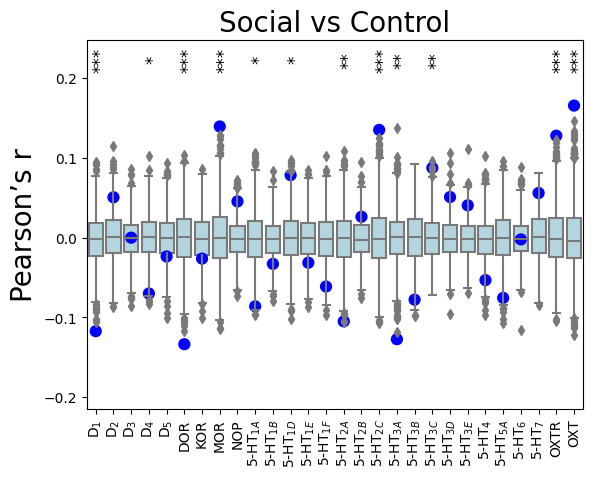

/opt/miniconda-latest/envs/neuro/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/opt/miniconda-latest/envs/neuro/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


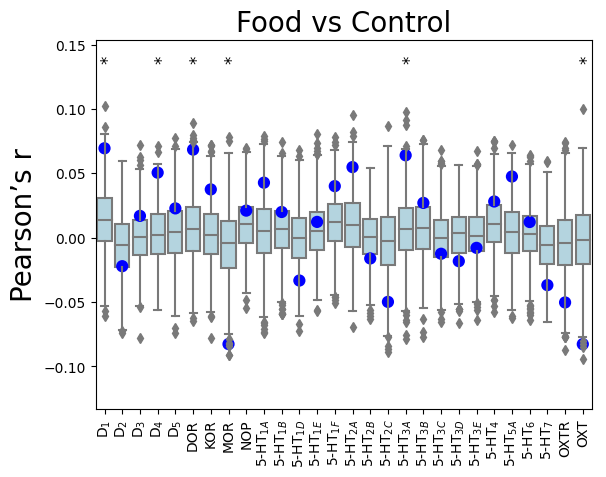

/opt/miniconda-latest/envs/neuro/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/opt/miniconda-latest/envs/neuro/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


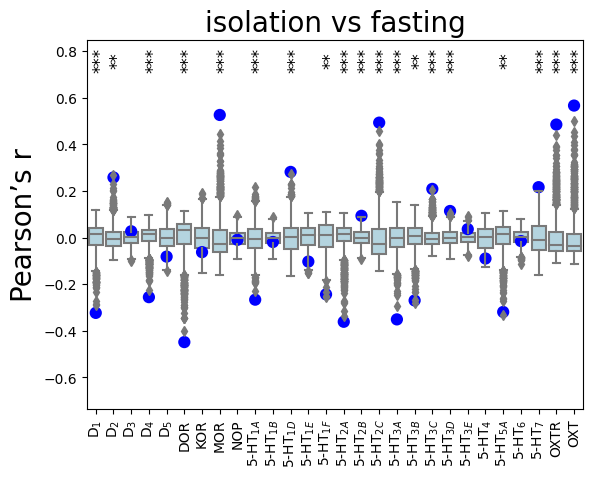

/opt/miniconda-latest/envs/neuro/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/opt/miniconda-latest/envs/neuro/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


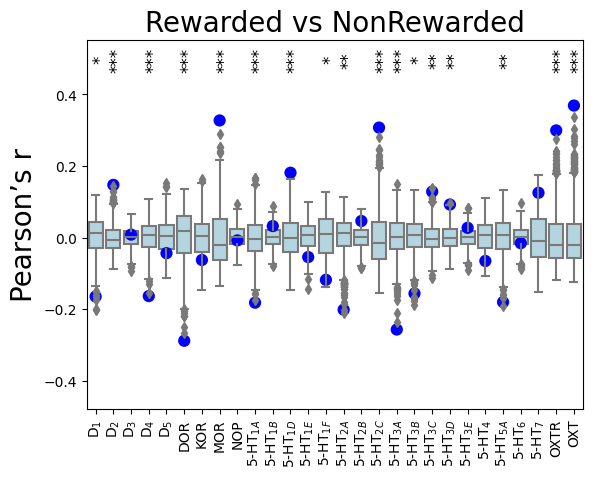

In [23]:
# Plot
for num in range(len(analysis_weight_maps_list)):
    df_null_dist_plot = df_null_dist.iloc[:,num*len(template_list_str):(num+1)*len(template_list_str)]
    df_corr_plot      =      df_corr.iloc[:,num*len(template_list_str):(num+1)*len(template_list_str)]
    df_star_plot      =      df_star.iloc[:,num*len(template_list_str):(num+1)*len(template_list_str)]
    max_df = max(df_null_dist_plot.max().max(), df_corr_plot.max().max())
    min_df = max(df_null_dist_plot.min().min(), df_corr_plot.min().min())
    max_abs = max(abs(max_df), abs(min_df))
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    sns.boxplot(data=df_null_dist_plot, color="lightblue", ax=ax);
    sns.pointplot(data=df_corr_plot, color="blue", linestyles="none", ax=ax);
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    #ax.set_xlabel("Gene expression map", fontsize=20)
    ax.set_ylabel("Pearson’s r", fontsize=20)
    ax.set_ylim(-max_abs*1.3, max_abs*1.5)
    ax.set_title(analysis_weight_maps_list[num], fontsize=20)
    for i in range(len(template_list_str)):
        ax.text(i+0.25, max_df*1.35, df_star_plot.iat[0, i], color="k", fontsize=12, rotation=90, ha='center', va='center')
    plt.show()
    FILE_NAME = "fig_gene" + str(num) + ".pdf"
    fig.savefig(os.path.join(FROM_PATH, FILE_NAME), bbox_inches='tight')
    cp_s3(BUCKET_NAME, FROM_PATH, TO_PATH, FILE_NAME, "upload")

### 2. Analysis with PET

Lists to make: fetch_list, tempalate_list (new), template_list_str (new), rotated_dict(new), img_name_list (common), template_name_list(new), corr_list(new), pval_list(new), nulls_dist_list(new)

In [24]:
fetch_list = [
    #PET tracer binding to D1 (dopamine receptor)
    ["D$_{1}$", 'kaller2017', 'sch23390', 'MNI152', '3mm'],
    #PET tracer binding to D2 (dopamine receptor)
    ["D$_{2}$_1", 'alarkurtti2015', 'raclopride', 'MNI152', '3mm'],
    ["D$_{2}$_2", 'jaworska2020', 'fallypride', 'MNI152', '1mm'],
    ["D$_{2}$_3", 'sandiego2015', 'flb457', 'MNI152', '1mm'],
    ["D$_{2}$_4", 'smith2017', 'flb457', 'MNI152', '1mm'],
    #PET tracer binding to MOR (mu-opioid receptor)
    ["MOR_1", 'kantonen2020', 'carfentanil', 'MNI152', '3mm'],
    ["MOR_2", 'turtonen2020', 'carfentanil', 'MNI152', '1mm'],
    #PET tracer binding to 5-HT1a (seroto2in receptor)
    ["5-HT$_{1A}$_1", 'beliveau2017', 'cumi101', 'MNI152', '1mm'],
    ["5-HT$_{1A}$_2", 'savli2012', 'way100635', 'MNI152', '3mm'],
    #PET tracer binding to 5-HT1b (serotonin receptor)
    ["5-HT$_{1B}$_1", 'beliveau2017', 'az10419369', 'MNI152', '1mm'],
    ["5-HT$_{1B}$_2", 'gallezot2010', 'p943', 'MNI152', '1mm'],
    ["5-HT$_{1B}$_3", 'savli2012', 'p943', 'MNI152', '3mm'],
    #PET tracer binding to 5-HT2a (serotonin receptor)
    ["5-HT$_{2A}$_1", 'beliveau2017', 'cimbi36', 'MNI152', '1mm'],
    ["5-HT$_{2A}$_2", 'savli2012', 'altanserin', 'MNI152', '3mm'],
    #PET tracer binding to 5-HT4 (serotonin receptor)
    ["5-HT$_{4}$", 'beliveau2017', 'sb207145', 'MNI152', '1mm'],
    #PET tracer binding to 5-HT6 (serotonin receptor)
    ["5-HT$_{6}$", 'radnakrishnan2018', 'gsk215083', 'MNI152', '1mm'],
    ]

In [25]:
df_fetch = pd.DataFrame(fetch_list,
                  columns=["name", "source", "desc", "space", "den"])
df_fetch

,name,source,desc,space,den
0,D$_{1}$,kaller2017,sch23390,MNI152,3mm
1,D$_{2}$_1,alarkurtti2015,raclopride,MNI152,3mm
2,D$_{2}$_2,jaworska2020,fallypride,MNI152,1mm
3,D$_{2}$_3,sandiego2015,flb457,MNI152,1mm
4,D$_{2}$_4,smith2017,flb457,MNI152,1mm
5,MOR_1,kantonen2020,carfentanil,MNI152,3mm
6,MOR_2,turtonen2020,carfentanil,MNI152,1mm
7,5-HT$_{1A}$_1,beliveau2017,cumi101,MNI152,1mm
8,5-HT$_{1A}$_2,savli2012,way100635,MNI152,3mm
9,5-HT$_{1B}$_1,beliveau2017,az10419369,MNI152,1mm


In [26]:
template_list_str = df_fetch["name"].tolist()

In [27]:
# Create a template list and a set of null maps for each template
template_list = []
rotated_dict = {}
for template_num, template in enumerate(template_list_str):
    template = datasets.fetch_annotation(source=df_fetch["source"].iloc[template_num], desc=df_fetch["desc"].iloc[template_num], space=df_fetch["space"].iloc[template_num], den=df_fetch["den"].iloc[template_num])
    template_list.append(template)
    template_name = template_list_str[template_num]
    print("Starting resampling!")
    resampled_template, resampled_img = resampling.resample_images(template, img_list[0], 'MNI152', 'MNI152', resampling='transform_to_alt', alt_spec=('fsaverage', '10k'))
    print("Finished resampling!")
    rotated_dict[template_name] = nulls.alexander_bloch(resampled_template, atlas='fsaverage', density='10k', n_perm=1000, seed=1234)
    print("Finished rotating/creating null maps!")
    print(rotated_dict[template_name].shape)

Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!


/tmp/ipykernel_482/3664908648.py:5: UserWarning: Data from beliveau2017 and norgaard2021 is best used in the provided fsaverage space (e.g. source='beliveau2017', space='fsaverage', den='164k'). MNI152 maps should only be used for subcortical data.
  template = datasets.fetch_annotation(source=df_fetch["source"].iloc[template_num], desc=df_fetch["desc"].iloc[template_num], space=df_fetch["space"].iloc[template_num], den=df_fetch["den"].iloc[template_num])


Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)
Starting resampling!
Finished resampling!
Finished rotating/creating null maps!
(20484, 1000)


In [28]:
corr_list = []
pval_list = []
null_dist_list = []
img_name_list = []
template_name_list = []

for img_num, img in enumerate(img_list):
    img_name = img_list_str[img_num]
    if img_name in analysis_weight_maps_list:
        for template_num, template in enumerate(template_list):
            template_name = template_list_str[template_num]
            print(f'img = {img_name}, template = {template_name}')

            # Resampled the template and the image
            resampled_template, resampled_img = resampling.resample_images(template, img, 'MNI152', 'MNI152', resampling='transform_to_alt', alt_spec=('fsaverage', '10k'))

            # Use pre-computed 'rotated' value
            rotated = rotated_dict[template_name]

            corr, pval, nulls_dist = stats.compare_images(resampled_template, resampled_img, nulls=rotated, return_nulls = True )

            print(f'r = {corr:.3f}, p = {pval:.3f}')
            img_name_list.append(img_name)
            template_name_list.append(template_name)
            corr_list.append(corr)
            pval_list.append(pval)
            null_dist_list.append(nulls_dist)

img = Social vs Control, template = D$_{1}$
r = -0.111, p = 0.008
img = Social vs Control, template = D$_{2}$_1
r = -0.041, p = 0.241
img = Social vs Control, template = D$_{2}$_2
r = 0.151, p = 0.001
img = Social vs Control, template = D$_{2}$_3
r = 0.117, p = 0.006
img = Social vs Control, template = D$_{2}$_4
r = 0.121, p = 0.004
img = Social vs Control, template = MOR_1
r = 0.028, p = 0.538
img = Social vs Control, template = MOR_2
r = 0.079, p = 0.080
img = Social vs Control, template = 5-HT$_{1A}$_1
r = -0.021, p = 0.324
img = Social vs Control, template = 5-HT$_{1A}$_2
r = -0.107, p = 0.009
img = Social vs Control, template = 5-HT$_{1B}$_1
r = -0.006, p = 0.790
img = Social vs Control, template = 5-HT$_{1B}$_2
r = -0.019, p = 0.667
img = Social vs Control, template = 5-HT$_{1B}$_3
r = -0.082, p = 0.031
img = Social vs Control, template = 5-HT$_{2A}$_1
r = -0.022, p = 0.328
img = Social vs Control, template = 5-HT$_{2A}$_2
r = 0.035, p = 0.303
img = Social vs Control, template = 

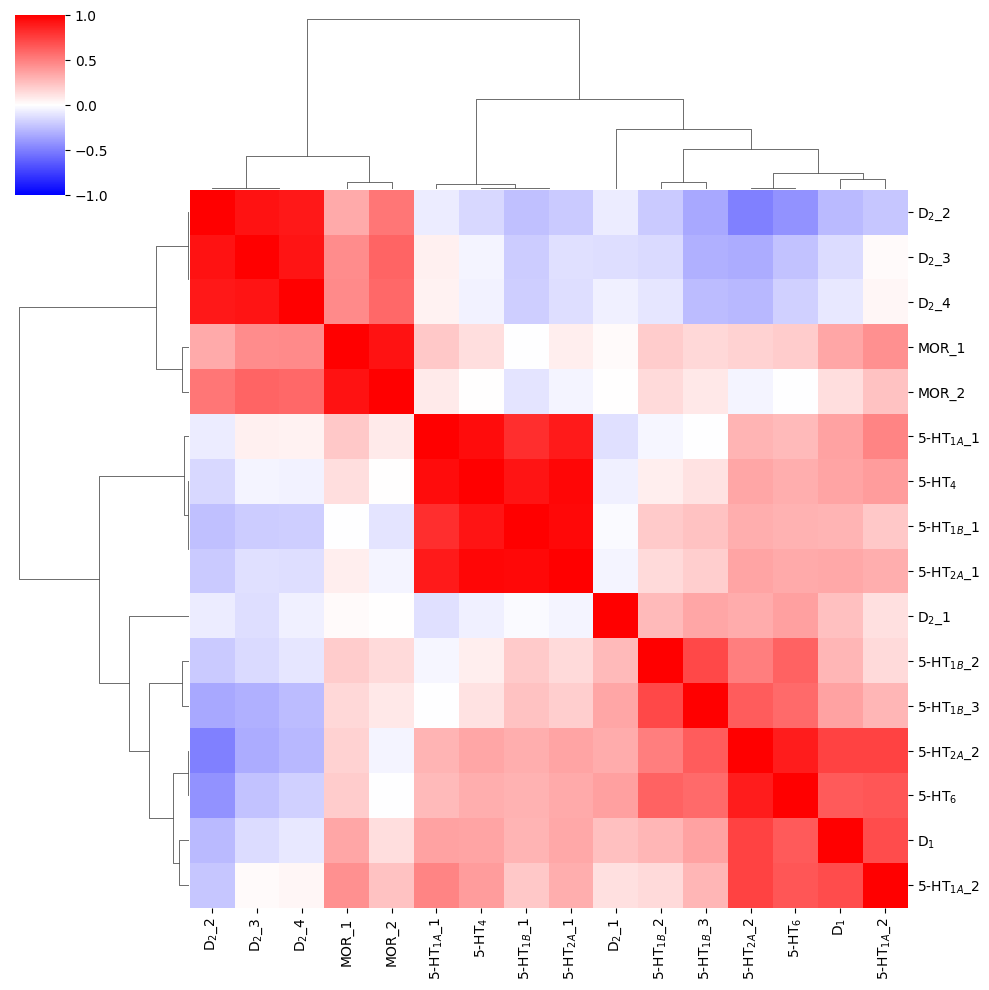

In [29]:
# Calculate the correlation between the template images (PET templates)
temp_maps_data_list = []
for num in range(len(template_list)):
    template0 = template_list[num]
    template, img = resampling.resample_images(template0, template0, 'MNI152', 'MNI152', resampling='transform_to_alt', alt_spec=('fsaverage', '10k'))
    temp_maps_data_list.append(np.hstack([template[0].agg_data(), template[1].agg_data()]))

df = pd.DataFrame(temp_maps_data_list, index=template_list_str).T
df.head()

df_corr = df.corr()
cg = sns.clustermap(df_corr, annot=False, fmt=".2f", cmap="bwr", vmin=-1, vmax=1, metric="correlation")
#cg.ax_row_dendrogram.set_visible(False)
#cg.ax_col_dendrogram.set_visible(False)

In [30]:
# Adjust p-values to control the false discovery rate.
FDR_pval_list = sp.stats.false_discovery_control(pval_list, axis=0, method='bh')

# The main result here is the FDR_pval for image-template combination
df = pd.DataFrame([img_name_list, template_name_list, corr_list, pval_list, FDR_pval_list, null_dist_list],
                  index=["img", "template", "corr", "pval", "FDR_pval" ,"null_dist"]).T

df['img_template'] = df['img'] + " x " + df['template']

df.loc[df['FDR_pval'] > .05 , 'star'] = ''
df.loc[df['FDR_pval'] < .05 , 'star'] = '*'
df.loc[df['FDR_pval'] < .01 , 'star'] = '**'
df.loc[df['FDR_pval'] < .005, 'star'] = '***'

df

,img,template,corr,pval,FDR_pval,null_dist,img_template,star
0,Social vs Control,D$_{1}$,-0.111,0.008,0.028,"[-0.001167911570519209, -0.09173845499753952, ...",Social vs Control x D$_{1}$,*
1,Social vs Control,D$_{2}$_1,-0.041,0.241,0.405,"[0.011101615615189075, 0.030473683029413223, -...",Social vs Control x D$_{2}$_1,
2,Social vs Control,D$_{2}$_2,0.151,0.001,0.005,"[-0.10108548402786255, 0.12857411801815033, -0...",Social vs Control x D$_{2}$_2,***
3,Social vs Control,D$_{2}$_3,0.117,0.006,0.024,"[-0.10556028038263321, 0.11676425486803055, -0...",Social vs Control x D$_{2}$_3,*
4,Social vs Control,D$_{2}$_4,0.121,0.004,0.017,"[-0.07944663614034653, 0.12199825048446655, -0...",Social vs Control x D$_{2}$_4,*
5,Social vs Control,MOR_1,0.028,0.538,0.650,"[-0.04566275328397751, 0.016921063885092735, -...",Social vs Control x MOR_1,
6,Social vs Control,MOR_2,0.079,0.080,0.176,"[-0.0635160505771637, 0.052510347217321396, -0...",Social vs Control x MOR_2,
7,Social vs Control,5-HT$_{1A}$_1,-0.021,0.324,0.456,"[0.01673991046845913, -0.030911434441804886, 0...",Social vs Control x 5-HT$_{1A}$_1,
8,Social vs Control,5-HT$_{1A}$_2,-0.107,0.009,0.029,"[0.008260805159807205, -0.0646490752696991, 0....",Social vs Control x 5-HT$_{1A}$_2,*
9,Social vs Control,5-HT$_{1B}$_1,-0.006,0.790,0.829,"[0.031715285032987595, -0.06130754202604294, 0...",Social vs Control x 5-HT$_{1B}$_1,


In [31]:
# Saving and uploading data to a S3 bucket
FILE_NAME = "df_PET.pickle"
df.to_csv(os.path.join(FROM_PATH, FILE_NAME))
cp_s3(BUCKET_NAME, FROM_PATH, TO_PATH, FILE_NAME, "upload")

In [32]:
df_corr = pd.DataFrame(df["corr"].values,
                    index=df["template"].values).T

In [33]:
df_star = pd.DataFrame(df["star"].values,
                    index=df["img_template"].values).T

In [34]:
df_null_dist = pd.DataFrame(null_dist_list,
                    index=df["img_template"].values).T

/opt/miniconda-latest/envs/neuro/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/opt/miniconda-latest/envs/neuro/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


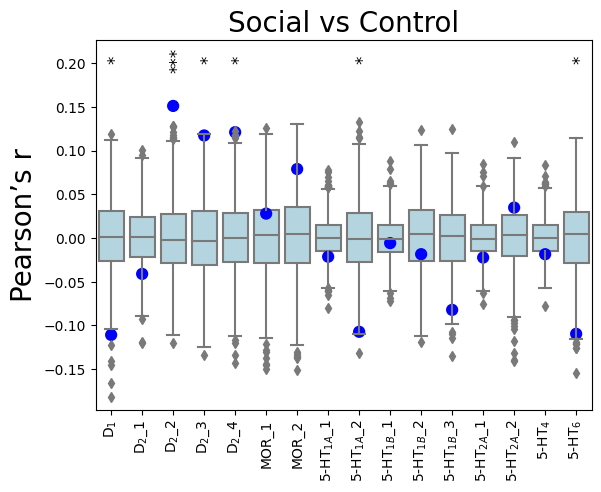

/opt/miniconda-latest/envs/neuro/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/opt/miniconda-latest/envs/neuro/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


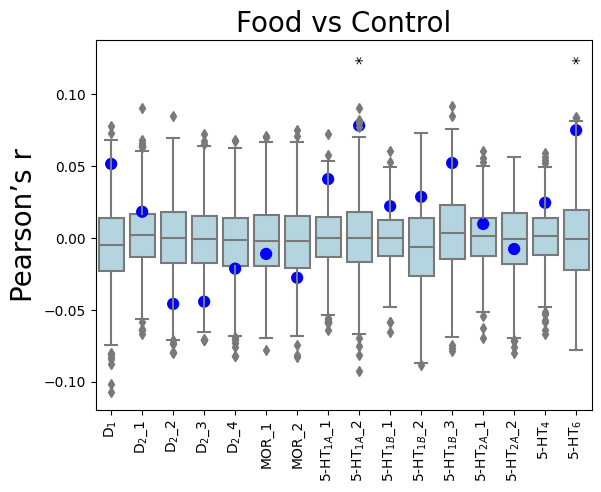

/opt/miniconda-latest/envs/neuro/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/opt/miniconda-latest/envs/neuro/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


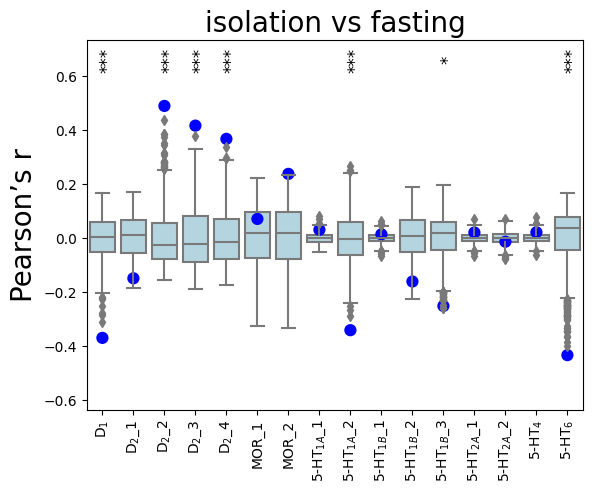

/opt/miniconda-latest/envs/neuro/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/opt/miniconda-latest/envs/neuro/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


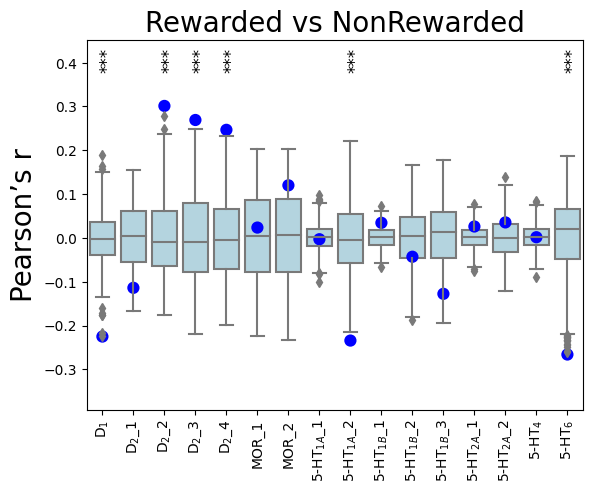

In [35]:
# Plot
for num in range(len(analysis_weight_maps_list)):
    df_null_dist_plot = df_null_dist.iloc[:,num*len(template_list_str):(num+1)*len(template_list_str)]
    df_corr_plot      =      df_corr.iloc[:,num*len(template_list_str):(num+1)*len(template_list_str)]
    df_star_plot      =      df_star.iloc[:,num*len(template_list_str):(num+1)*len(template_list_str)]
    max_df = max(df_null_dist_plot.max().max(), df_corr_plot.max().max())
    min_df = max(df_null_dist_plot.min().min(), df_corr_plot.min().min())
    max_abs = max(abs(max_df), abs(min_df))
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    sns.boxplot(data=df_null_dist_plot, color="lightblue", ax=ax);
    sns.pointplot(data=df_corr_plot, color="blue", linestyles="none", ax=ax);
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    #ax.set_xlabel("PET_template", fontsize=20)
    ax.set_ylabel("Pearson’s r", fontsize=20)
    ax.set_ylim(-max_abs*1.3, max_abs*1.5)
    ax.set_title(analysis_weight_maps_list[num], fontsize=20)
    for i in range(len(template_list_str)):
        ax.text(i+0.15, max_df*1.35, df_star_plot.iat[0, i], color="k", fontsize=12, rotation=90, ha='center', va='center')
    plt.show()
    FILE_NAME = "fig_PET" + str(num) + ".pdf"
    fig.savefig(os.path.join(FROM_PATH, FILE_NAME), bbox_inches='tight')
    cp_s3(BUCKET_NAME, FROM_PATH, TO_PATH, FILE_NAME, "upload")